## Enunciado

O objetivo deste exercício é treinar uma rede similar à da aula 7 (CNN como codificadora + decodificador do transformer) mas tendo como entrada imagens de recibos reais. A saída esperada é o nome da compania e seu endereço. 

Iremos usar o [dataset SROIE da competição ICDAR 2019.](https://rrc.cvc.uab.es/?ch=13&com=introduction)

Métricas: usar o código abaixo para calcular o exact match da resposta toda e F1 de palavras.

In [1]:
version = "recibos_convlstm_pos_model_app1_adafactor" #@param {type: "string"}
lr =  5e-5#@param {type: "number"}
bs =    10#@param {type: "integer"} 
seq_len =  64#@param {type: "integer"}
patience =  10#@param {type: "integer"}
max_epochs =  500#@param {type: "integer"}
dropout_rate = 0.2#@param {type: "number"}
drop_connect_rate = 0.5#@param {type: "number"}
debug = False #@param {type: "boolean"}


# Define hyperparameters
hparams = {"version": version,
           "lr": lr,
           "bs": bs,
           "seq_len": seq_len,
           "patience": patience,
           "max_epochs": max_epochs,
           "dropout_rate": dropout_rate,
           "drop_connect_rate": drop_connect_rate,
           "debug": debug, 
           "enet": "efficientnet-b0",
           "t5": "t5-small"}
hparams             

{'version': 'recibos_convlstm_pos_model_app1_adafactor',
 'lr': 5e-05,
 'bs': 10,
 'seq_len': 64,
 'patience': 10,
 'max_epochs': 500,
 'dropout_rate': 0.2,
 'drop_connect_rate': 0.5,
 'debug': False,
 'enet': 'efficientnet-b0',
 't5': 't5-small'}

## Download do dataset

In [2]:
# !gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip .
# !unzip dataset_sroie_icdar_2019.zip

O dataset contém 626 imagens e suas respectiva anotações (respostas), sendo 200 imagens separadas para teste. Cada imagem tem um arquivo txt correspondente que contém as respostas em formato json.

In [3]:
#v !pip install sacrebleu pytorch-lightning transformers efficientnet-pytorch --quiet     

In [4]:
import glob
import json
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from efficientnet_pytorch import EfficientNet
import os
import json
import random
import gc
import cv2
import numpy as np
import torch
from fairseq.optim import adafactor
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, ToTensor, Compose
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sacrebleu
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [5]:
data_json = json.load(open("train/X00016469612.txt"))
print(data_json)

print(data_json["company"])

print(data_json["address"])

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}
BOOK TA .K (TAMAN DAYA) SDN BHD
NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.


In [6]:
TOKENIZER = T5Tokenizer.from_pretrained(hparams['t5'])

extra_tokens = ['[NL]'] # Add token de 'nova linha' para multiline
added_tokens = []
for tok in extra_tokens:
  enc = TOKENIZER.encode(tok)
  if 2 in enc:
      added_tokens.append(tok)
      TOKENIZER.add_tokens(tok)

In [7]:
MODES = ["train", "test"]

class OCR_DATA(Dataset):
    '''
    Abstração do MSCOCO com 5 captions por imagem. 
    '''
    def __init__(self, mode, seq_len, TOKENIZER,  N_augment=1, width=300, height=400, image_transform=Compose([transforms.ToTensor(), Lambda(lambda img: img * 2.0 - 1.0)])):
      '''
      mode: um de "train", test".
      seq_len: tamanho máximo de sequência. 64 padrão para alinhar com feature 8x8 da efficientnet.
      transform: transformadas para serem aplicadas somente na imagem.
      '''
      assert mode in MODES
      self.mode = mode
      self.seq_len = seq_len
      self.N_augment = N_augment

      self.image_transform = image_transform
      self.TOKENIZER = TOKENIZER

      self.reshape_trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((height, width))])  
      
      txt_files = glob.glob(f"{mode}/*.txt")
      self.targets = list()
      self.images = list()
      for txt_file in txt_files:
        # im_bgr = cv2.imread(txt_file[:-4]+'.jpg')
        # im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        # self.images.append(reshape_trans(im_rgb))
        
        self.images.append(txt_file[:-4]+'.jpg')
        with open(txt_file, 'r') as target_file:
          self.targets.append(json.load(target_file))

      if (self.mode == "train" and self.N_augment>1):
        new_images = list()
        new_targets = list()
        for i in range(len(self.images)):
            new_images.extend(self.N_augment*[self.images[i]])
            new_targets.extend(self.N_augment*[self.targets[i]])
        self.images = new_images
        self.targets = new_targets   

      self.len = len(self.targets)  


    def __len__(self):
      return self.len

    def __getitem__(self, i):
        '''
        Imagens são extraídas do H5PY, convertidas para o formato [H, W, C], float32.
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        Frase original também é retornada para cálculo do bleu.
        '''
        
        caption = self.targets[i]

        caption_company = caption["company"]
        
        cap_key = caption.get("address")
        if cap_key:
          caption_address = caption["address"]
        else:
          caption_address = " "
        
        caption = caption_company + " [NL] " + caption_address


        target = self.TOKENIZER.encode(caption,
                                        padding='max_length',
                                        truncation=True,
                                        max_length=self.seq_len,
                                        return_tensors='pt')[0]                          

        im_bgr = cv2.imread(self.images[i])
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        image = self.reshape_trans(im_rgb)
        
        if self.image_transform is not None:
          image = self.image_transform(image).detach().float()

        return image, caption, target

    def get_dataloader(self, batch_size, shuffle, num_workers=8):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [8]:
N_augmentation = 5

train_transforms = Compose(
    [transforms.ColorJitter(0.15,0.1,0.2,0.1),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

# train_transforms = Compose(
#     [transforms.ToTensor(),
#      Lambda(lambda img: 2.0*(img - 1.0))])

test_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

datasets = {"train": OCR_DATA("train", hparams['seq_len'], TOKENIZER=TOKENIZER, N_augment=N_augmentation,
                              image_transform=train_transforms),
            "test": OCR_DATA("test", hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms)}

## Dados sobre uma amostra do dataset

max image tensor(0.)
min image tensor(-2.)
Image shape: torch.Size([3, 400, 300])
Image .transpose(1, 2, 0) shape: (400, 300, 3)
company: DOMINO'S PIZZA [NL] DOMINO'S PIZZA TAMAN UNIVERSITI 30, JLN KEBUDAYAAN 7, TMN UNIVERSITI 81300 SKUDAI, JOHOR
target: tensor([ 6054, 17684,   667,    31,   134,   276, 20091, 19873,   784, 18207,
          908,  6054, 17684,   667,    31,   134,   276, 20091, 19873,     3,
         3221,  9312,     3, 14284, 26794,  3177,   196, 11558,   446,   434,
          567,     3,  9914,  8855, 12860,   188,  5033,  7973,     3,  2305,
          567,     3, 14284, 26794,  3177,   196,     3,  4959,  5426,     3,
        10047, 10161,  9822,     6,   446,  9195,  2990,     1,     0,     0,
            0,     0,     0,     0])


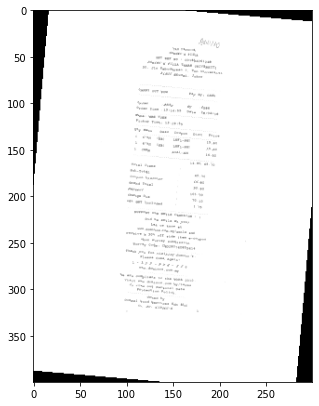

In [9]:
image = datasets["train"][2][0]
print('max image', image.max())
print('min image', image.min())
print('Image shape:', image.shape)
print('Image .transpose(1, 2, 0) shape:', image.cpu().numpy().transpose(1, 2, 0).shape)


plt.figure(figsize=(5, 10))
plt.imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))

company = datasets["train"][2][1]
print('company:', company)

target = datasets["train"][2][2]
print('target:', target)

## Representação das mesma imagem que foram augmentadas 5x

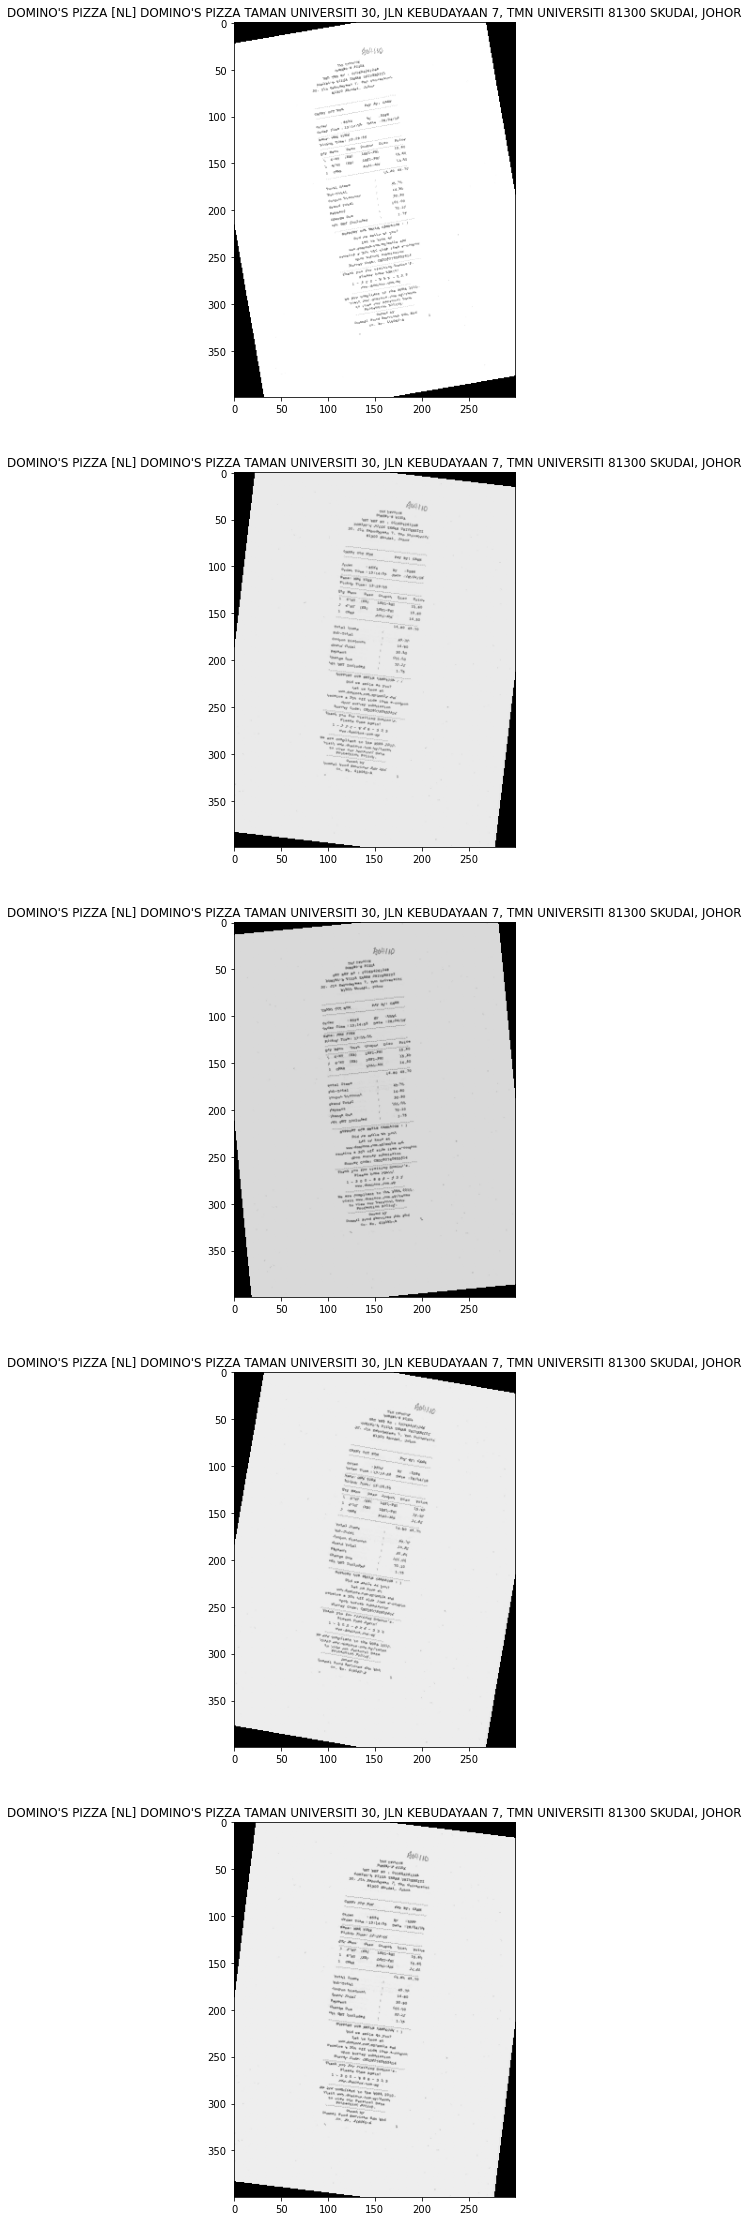

In [10]:
if N_augmentation>1:
    fig, axs = plt.subplots(N_augmentation, 1, figsize=(10, 40))
    for i in range(N_augmentation):
      image = datasets["train"][i][0]
      company = datasets["train"][i][1]
      axs[i].set_title(company)
      axs[i].imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))
    plt.show()

In [11]:
dataset_lens = {mode: len(datasets[mode]) for mode in MODES}

In [12]:
print(f"Lens: {dataset_lens}")

Lens: {'train': 2130, 'test': 200}


533
Train batch
torch.Size([3, 400, 300])
Company: HON HWA HARDWARE TRADING [NL] NO 37, JALAN MANIS 7, TAMAN SEGAR, 56100 CHERAS, KUALA LUMPUR. ; target: tensor([  454,  4170,   454, 12054,     3, 25430, 20293,  7451,   332, 21577,
         2365,   784, 18207,   908,  5693,  6862,     6,     3, 13853, 12303,
            3,  9312,  4555,  7973,     3,  3221,  9312,  5985, 25826,     6,
        11526,  2915,   205, 17444,  3291,     6,     3, 18519, 23634,   301,
        28468,  5905,     5,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


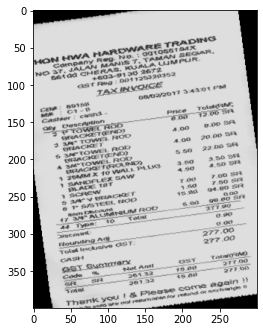

torch.Size([3, 400, 300])
Company: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR ; target: tensor([    3, 14284,  5478, 22267,   188,  3388,  5946, 25271, 27342,   180,
        12145,   272, 11083,   784, 18207,   908, 10440,     3, 13853, 12303,
          332, 15837,   667,   196,   489, 13572,     6, 12048, 12054, 19976,
            3,  8742, 13885, 16847,   448, 21758,   332, 15837,   667,   196,
            6,  4959,  3632,   446,  9195,  2990,   272, 14084,  8503,     6,
          683,  9195,  2990,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


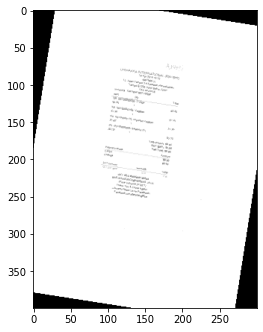

torch.Size([3, 400, 300])
Company: LITTLE CRAVINGS SDN BHD [NL] HQ: 7, JLN SS21/34, 47400 PJ ; target: tensor([ 8729,  9697,  3765,     3, 24442,   553,  2365,   134,   180, 12145,
          272, 11083,   784, 18207,   908,     3, 21447,    10,  7973,   446,
          434,   567,     3,  4256,  2658,    87,  3710,     6, 10635,  5548,
            3, 23953,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


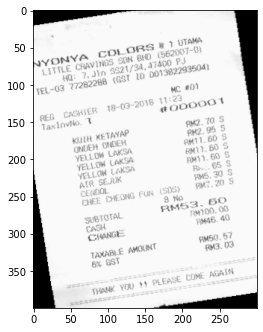

torch.Size([3, 400, 300])
Company: YONGFATT ENTERPRISE [NL] NO 122.124. JALAN DEDAP 13 81100 JOHOR BAHRU ; target: tensor([    3,   476, 15628,   371, 24642, 13209,  5946, 15582,  4132,   784,
        18207,   908,  5693,     3, 20889,     5, 22504,     5,     3, 13853,
        12303,   309,  2326,  2965,  1179,     3,  4959,  2915,   446,  9195,
         2990,   272, 14084,  8503,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


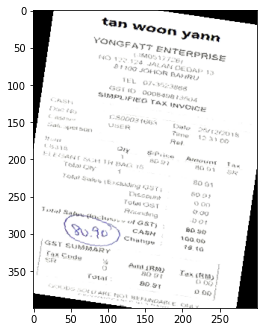

----------------------------------------
Test batch
Company: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR ; target: tensor([  454,  4170,   454, 12054,     3, 25430, 20293,  7451,   332, 21577,
         2365,   784, 18207,   908,  5693,  6862,     6,     3, 13853, 12303,
            3,  9312,  4555,  7973,     3,  3221,  9312,  5985, 25826,     6,
        11526,  2915,   205, 17444,  3291,     6,     3, 18519, 23634,   301,
        28468,  5905,     5,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


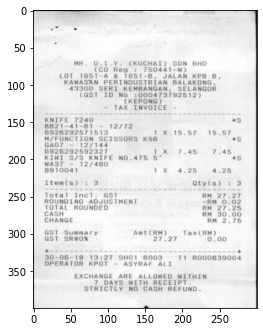

Company: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR. ; target: tensor([    3, 14284,  5478, 22267,   188,  3388,  5946, 25271, 27342,   180,
        12145,   272, 11083,   784, 18207,   908, 10440,     3, 13853, 12303,
          332, 15837,   667,   196,   489, 13572,     6, 12048, 12054, 19976,
            3,  8742, 13885, 16847,   448, 21758,   332, 15837,   667,   196,
            6,  4959,  3632,   446,  9195,  2990,   272, 14084,  8503,     6,
          683,  9195,  2990,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


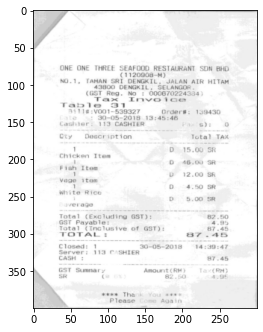

Company: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU, JOHOR ; target: tensor([ 8729,  9697,  3765,     3, 24442,   553,  2365,   134,   180, 12145,
          272, 11083,   784, 18207,   908,     3, 21447,    10,  7973,   446,
          434,   567,     3,  4256,  2658,    87,  3710,     6, 10635,  5548,
            3, 23953,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


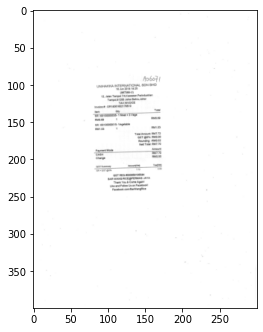

Company: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR ; target: tensor([    3,   476, 15628,   371, 24642, 13209,  5946, 15582,  4132,   784,
        18207,   908,  5693,     3, 20889,     5, 22504,     5,     3, 13853,
        12303,   309,  2326,  2965,  1179,     3,  4959,  2915,   446,  9195,
         2990,   272, 14084,  8503,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


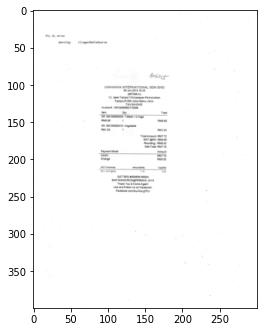

In [13]:
display_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=4, shuffle=True) for mode in MODES}

print(len(display_dataloaders["train"]))

# Test-load batchs 
train_batch, test_batch = next(iter(display_dataloaders["train"])), next(iter(display_dataloaders["test"]))

print("Train batch")
for image, company, target in zip(train_batch[0], train_batch[1], train_batch[2]):
  print(image.shape)
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()  
print('----------------------------------------')

print("Test batch")
for image, company, target in zip(test_batch[0], test_batch[1], train_batch[2]):
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [14]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [15]:
compute_f1(a_gold='He likes pizza', a_pred='she likes pizza')

0.6666666666666666

In [16]:
compute_exact(a_gold='He likes pizza', a_pred='she likes pizza')

0

In [17]:
compute_exact(a_gold='She likes pizza', a_pred='she likes pizza')

1

In [18]:
compute_exact(a_gold='He likes pizza', a_pred='He likes pizza')

1

# Separar o data_train_val em treino e validação

In [19]:
data_train_val = datasets['train']
print('data_train_val:', len(data_train_val))

print('len train', len(data_train_val)*0.8)
print('len val', len(data_train_val)*0.2)

data_train, data_val = torch.utils.data.random_split(data_train_val, [int(round(len(data_train_val)*0.8)), int(round(len(data_train_val)*0.2))],
                                                     generator=torch.Generator().manual_seed(42))

print('data_train:', len(data_train))
print('data_val:', len(data_val))

data_train_val: 2130
len train 1704.0
len val 426.0
data_train: 1704
data_val: 426


# Definir a classe do modelo usado EfficientT5

In [20]:
"""
Code borrowed with thanks from:
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
https://gist.github.com/halochou/acbd669af86ecb8f988325084ba7a749
"""

import torch.nn as nn
import torch


class ConvGRUCell(nn.Module):
    """
    Basic CGRU cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvGRUCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.update_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                     kernel_size=self.kernel_size, padding=self.padding,
                                     bias=self.bias)
        self.reset_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size, padding=self.padding,
                                    bias=self.bias)

        self.out_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                  kernel_size=self.kernel_size, padding=self.padding,
                                  bias=self.bias)

    def forward(self, input_tensor, cur_state):

        h_cur = cur_state
        # data size is [batch, channel, height, width]
        x_in = torch.cat([input_tensor, h_cur], dim=1)
        update = torch.sigmoid(self.update_gate(x_in))
        reset = torch.sigmoid(self.reset_gate(x_in))
        x_out = torch.tanh(self.out_gate(torch.cat([input_tensor, h_cur * reset], dim=1)))
        h_new = h_cur * (1 - update) + x_out * update

        return h_new

    def init_hidden(self, b, h, w):
        return torch.zeros(b, self.hidden_dim, h, w).cuda()


class ConvGRU(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvGRU, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvGRUCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvGRU
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBGRU(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBGRU, self).__init__()
        self.forward_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)

    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CGRU layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CGRU layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)

        return ycat


In [21]:
"""
Code borrowed with thanks from:
Shreyas Padhy, and Andrea Palazzi
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
"""

import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):
    """
    Basic CLSTM cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvLSTMCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, b, h, w):
        return (torch.zeros(b, self.hidden_dim, h, w).cuda(),
                torch.zeros(b, self.hidden_dim, h, w).cuda())


class ConvLSTM(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBLSTM(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBLSTM, self).__init__()
        self.forward_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        
    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CLSTM layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CLSTM layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)
        
        return ycat

In [22]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        print('freezing ', m)
        m.eval()

In [23]:
class EfficientT5(pl.LightningModule):

    def __init__(self, params):
        super(EfficientT5, self).__init__()

        self.params = params
        
        override_params = {'dropout_rate':params['dropout_rate'],'drop_connect_rate':params['drop_connect_rate']}

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained(params['enet'], advprop=True, **override_params)
        
        # freeze BN
        self.encoder = self.encoder.apply(set_bn_eval)
        
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['t5'])

        
        self.bridge = ConvGRU(in_channels=int(112/2), hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)

        self.tokenizer = TOKENIZER

    def _get_efn_embeddings(self, images):

        # Shape (N, 112, 16, 16)
        # features = self.encoder.extract_features(images)
        features = self.encoder.extract_endpoints(images)["reduction_4"]
        # features = self.encoder.extract_endpoints(images)["reduction_3"]
        # print('features shape', features.shape)

        features = features.unsqueeze(1)

        
        # features = features.reshape(features.shape[0], 1, 112, 25, 19) #best

        features = features.reshape(features.shape[0], 2, int(112/2), 25, 19)

        # Shape: (N, 512, -, -)
        features, last_state_list = self.bridge(features)
        
        features = features[0]

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 1, 3, 4, 2) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return efn_embeddings

    
    def _generate_tokens(self, efn_embeddings):
        '''
        Token generation
        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(efn_embeddings.device)
        
        encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

        for step in range(max_length-1):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=encoder_hidden_states)[0]
            next_token_logits = logits[:, -1, :]

            # decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def forward(self, batch): # TODO pro futuro: colocar os dados necessários individualmente e não o batch inteiro
        # Aqui os labels são strings e os tokens são os labels a serem inseridos no decoder
        # print(len(batch))
        images, label, token = batch

        # Output do efn atua como embedding do encoder
        efn_embeddings = self._get_efn_embeddings(images)
        # print('efn_embeddings', efn_embeddings.shape)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=token,
                                   return_dict=True)
            return outputs.loss
        else:
            return self._generate_tokens(efn_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        val_loss = outputs.loss.detach().cpu().numpy()

        return {"val_loss": val_loss, "pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        test_loss = outputs.loss.detach().cpu().numpy()

        return {"test_loss": test_loss, "pred": decoded_pred, "target": batch[1]}

    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # n = random.choice(range(len(trues)))
        n_samples = random.sample(range(len(trues)), 1)
        for n in n_samples:
            print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])
        
        val_loss = sum([x['val_loss'] for x in outputs])/len(outputs)

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

        return {'val_f1': f1, 'val_loss': val_loss}

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])
        
        test_loss = sum([x['test_loss'] for x in outputs])/len(outputs)
        
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)
    
    # return torch.optim.Adam(self.parameters(), lr=self.params['lr'])
    # return torch.optim.SGD(self.parameters(), lr=self.params['lr'], momentum=0.9)
    def configure_optimizers(self):
        optimizer = optimizer = adafactor.Adafactor(self.parameters(), weight_decay=0.01, eps=(1e-30, self.params['lr']))
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_loss'}
    
    def train_dataloader(self):
        return DataLoader(data_train, batch_size=self.params['bs'], shuffle=True, pin_memory=True, num_workers=8)
    def val_dataloader(self):
        return DataLoader(data_val, batch_size=self.params['bs'], shuffle=False, pin_memory=True, num_workers=8)     
    def test_dataloader(self):
        return OCR_DATA("test", image_transform=test_transforms).get_dataloader(batch_size=self.params['bs'], shuffle=False)

# Definir os hiper-parametros do modelo
## Diversos hiper-parametros foram testados, mas os melhores valores foram obtidos com os parametros abaixo 


**Os parâmetros de *dropout_rate* e *drop_connect_rate* da efficient-net são bastante interessantes podendo dar um maior domínio sobre a efficiente-net**

In [24]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYzJiZGU4NWMtZDI0NS00ZjIxLWIwZmMtZDI1ZTJjMTg3MjE4In0=",
    project_name="orllem/pytorch-lightning-ocr-recibos-fine-tuning-augment",
    params=hparams)

https://ui.neptune.ai/orllem/pytorch-lightning-ocr-recibos-fine-tuning-augment/e/PYTOR4-29


NeptuneLogger will work in online mode
2021-01-05 17:44:50 | INFO | lightning | NeptuneLogger will work in online mode


In [25]:
gc.collect()
torch.cuda.empty_cache()

In [26]:


# Initialize Lightning Module with parameters defined above.
# model = EfficientT5(hparams)
pre_model = "aula12_checkpoints/cloud_reduced_part_final_netupne_adafactor_gpu_model-epoch=7-step=10679.ckpt"
model = EfficientT5(hparams).load_from_checkpoint(pre_model, params=hparams)
print(model)

# Configure callbacks
if hparams["debug"]:
    checkpoint_callback = None
    logger = None
    early_stop_callback = None
else:
    checkpoint_path = 'aula8_checkpoints/epoch=10.ckpt'
    checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
    print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
    print(f'Saving checkpoints to {checkpoint_dir}')
    checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                      filepath=checkpoint_dir,
                                                      save_top_k=1, 
                                                      monitor="val_loss", mode="min")
    early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=hparams["patience"], mode='min')

trainer = pl.Trainer(gpus=1,
                     fast_dev_run=hparams["debug"],
                     accumulate_grad_batches=3,
                     logger=neptune_logger,
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback],
                     max_epochs=hparams["max_epochs"])

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /home/orllem3456/aula8_checkpoints exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
2021-01-05 17:44:55 | INFO | lightning | GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-01-05 17:44:55 | INFO | lightning | TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-01-05 17:44:55 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


EfficientT5(
  (encoder): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [27]:
trainer.fit(model)


  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params
2021-01-05 17:44:56 | INFO | lightning | 
  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params



Sample Target: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN
Prediction:  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇  



/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)



Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: CHECKER SDN BHD [NL] LOT P.T. 2811, JALAN PERMAS, TAMAN PERMAS, 81750 JOHOR BAHRU, JOHOR



2021-01-05 17:50:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: TANJONGMAS BOOKCENTRE (PJ) SDN BHD [NL] LOT F15, GIANT BANDAR PUTERI JALAN PUTERI 1/1, BDR PUTERI 47100 PUCHONG, SELANGOR
Prediction: GUARDIAN HEALTH AND BEAUTY SDN BHD [NL] JALAN SS21/39, 47400 SHAH ALAM, SELANGOR.



2021-01-05 17:55:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: MR D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN



2021-01-05 18:00:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: PETRODELI ENTERPRISE [NL] LOT 485, TMN LEMBAH KERAMAT JLN ULU KELANG,  54200 KUALA LUMPUR
Prediction: PERNIAGAAN RIANG RAYA [NL] NO.59 JALAN RIANG RAYA, 81100 JOHOR BAHRU



2021-01-05 18:05:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: HAXINCONE RESOURCES SDN BHD [NL] 16A, JALAN ASTAKA U8/83, BUKIT JELUTONG 40150 SHAH ALAN, SELANGOR D.E.
Prediction: GUARDIAN HEALTH AND BEAUTY SDN BHD [NL] JALAN LOKE YEW BENTONG 1 OFF JALAN BENTONG JAYA 81750 JOHOR BAHRU JOHOR



2021-01-05 18:10:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: HAXINCONE RESOURCES SDN BHD [NL] 16A, JALAN ASTAKA U8/83, BUKIT JELUTONG 40150 SHAH ALAN, SELANGOR D.E.
Prediction: HAXINCONE RESOURCES SDN BHD [NL] 19A, JALAN BUNGA TANJONG, 43300 SERI KEMBANGAN,



2021-01-05 18:15:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Prediction: GL HANDICRAFT & TAIL ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA



2021-01-05 18:20:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-05 18:25:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: DOMINO'S PIZZA [NL] NO.12, JALAN PERMAS JAYA 10, BANDAR BARU PERMAS JAYA, 81750 MASAI JOHOR
Prediction: CHECKERS HYPERMARKET SDN BHD (JALAN KLANG LAMA) [NL] LOT F1-01, 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANG



2021-01-05 18:31:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1558-TMN PUSAT KEPONG
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1243-JLN PUDU KEPONG



2021-01-05 18:36:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-05 18:41:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 18:46:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317-JLN PUDU ULU



2021-01-05 18:51:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAN, SELANGOR.



2021-01-05 18:56:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 19:01:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: URBAN IDEA SDN BHD [NL] A-G-06, DATARAN GLOMAC, JALAN SS6/5A, PUSAT BANDAR KELANA JAYA, 47301 PETALING JAYA, SELANGOR, MALAYSIA
Prediction: BEMED (SP) SDN. BHD. [NL] NO.49, JALAN DINAR G U3/G, SUBANG PERDANA, 40150 SHAH ALAM, SELANGOR D.E.



2021-01-05 19:07:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 19:12:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: DE MAXIMUM THAI EXPRESS SDN BHD [NL] BLK 2, UNIT G1 & G2, BESTARI TERRACE, LOT PTD 182908 & PTD 143216, JALAN DANGA, TAMAN NUSA BESTARI, 81300
Prediction: DELICIOUS RESTAURANT SINNATHAMBY HOLDINGS SDN. BHD. [NL] BLK 2, UNIT G1 & G2, BESTARI TERRACE, LOT PTD 182908 & PTD 143216, JA



2021-01-05 19:17:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47500 PETALING JAYA SELANGOR



2021-01-05 19:22:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR



2021-01-05 19:27:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: HOME MASTER HARDWARE & ELECTRICAL [NL] NO.113G & 115G, JALAN SETIA GEMBILANG U13/BG BANDAR SETIA ALAM, 40170 BANDAR SETIA ALAM, SELANGOR.
Prediction: HOME MASTER HARDWARE & ELECTRICAL [NL] NO.113G & 115G, JALAN SETIA GEMBILANG U13/BG BANDAR SETIA ALAM, 40170 BANDAR SETIA ALAM,



2021-01-05 19:32:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: YONG CEN ENTERPRISE [NL] 9, JALAN SUBANG JASA 3, 40150 SHAN ALAM, SELANGOR.
Prediction: YONG CEN ENTERPRISE [NL] 9, JALAN SUBANG JASA 3, 40150 SHAN ALAM, SELANGOR.



2021-01-05 19:37:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.
Prediction: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.



2021-01-05 19:42:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-05 19:47:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



2021-01-05 19:52:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: SWEET FOREST CAFE [NL] NO 21, JLN BUNGA KANTAN TAMAN P. RAMLEE SETAPAK 53000 KUALA LUMPUR
Prediction: SWEET FOREST CAFE [NL] NO 21, JLN BUNGA KANTAN TAMAN P. RAMLEE SETAPAK 53000 KUALA LUMPUR



2021-01-05 19:57:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-05 20:02:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: TK DIVISION KITCHEN SDN BHD [NL] 19-1. JALAN MALINJA 2, TAMAN BUNGA RAYA, 53100 SETAPAK, KUALA LUMPUR.
Prediction: TK DIVISION KITCHEN SDN BHD [NL] 19-1. JALAN MALINJA 2, TAMAN BUNGA RAYA, 53100 SETAPAK, KUALA LUMPUR.



2021-01-05 20:07:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 20:13:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 20:18:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRUJOHOR



2021-01-05 20:23:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 20:28:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN
Prediction: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DAR



2021-01-05 20:33:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 20:38:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-05 20:43:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



2021-01-05 20:48:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord


Sample Target: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN
Prediction: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DAR




2021-01-05 20:53:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord

1

# Resultados do melhor modelo no Teste

In [32]:
best_model = "aula8_checkpoints/recibos_convlstm_pos_model_app1_adafactor-epoch=26-step=1538.ckpt"
test_model = EfficientT5(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

In [33]:
test_dl = datasets["test"].get_dataloader(batch_size=32, shuffle=False, num_workers=8)

In [34]:
trainer.test(test_model, test_dl)


Sample Target: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Prediction: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_bleu_1': 69.72737599394169,
 'test_bleu_4': 54.37847073900043,
 'test_bleu_score': 58.892688611070085,
 'test_exact': 0.225,
 'test_f1': 0.5683391983992457,
 'test_loss': 1.3401345099721635,
 'val_bleu_1': 90.95381251708118,
 'val_bleu_4': 84.76131559954635,
 'val_bleu_score': 87.40179474449813,
 'val_exact': 0.5633802816901409,
 'val_f1': 0.8842663327831879,
 'val_loss': 0.03435655335657472}
--------------------------------------------------------------------------------


[{'val_loss': 0.03435655335657472,
  'val_bleu_score': 87.40179474449813,
  'val_bleu_1': 90.95381251708118,
  'val_bleu_4': 84.76131559954635,
  'val_f1': 0.8842663327831879,
  'val_exact': 0.5633802816901409,
  'test_loss': 1.3401345099721635,
  'test_bleu_score': 58.892688611070085,
  'test_bleu_1': 69.72737599394169,
  'test_bleu_4': 54.37847073900043,
  'test_f1': 0.5683391983992457,
  'test_exact': 0.225}]

# Aplicação do modelo em alguns caso do Teste

2021-01-05 21:16:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR4-29. Cause: Error(code=400, message='X-coord

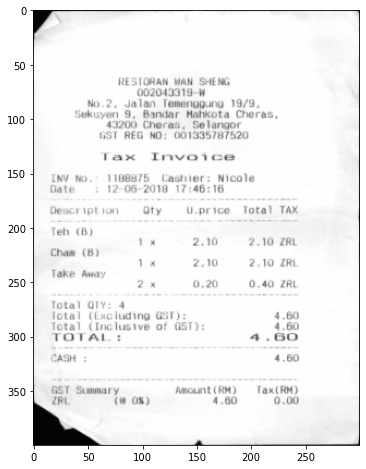

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR



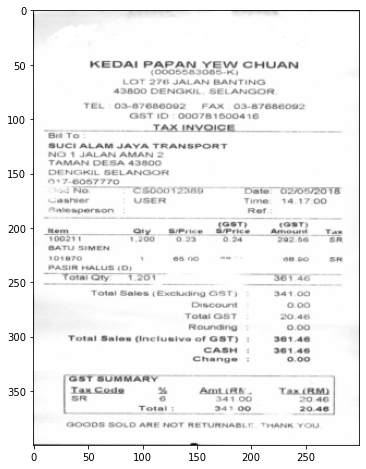

Labels: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR
Pred: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR.



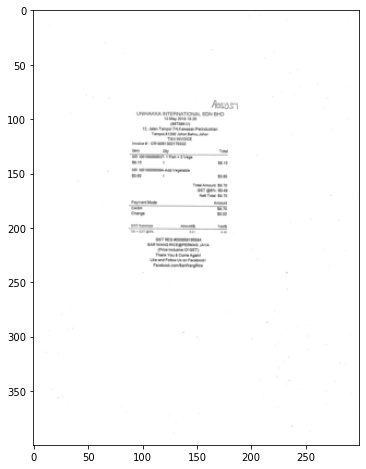

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Pred: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



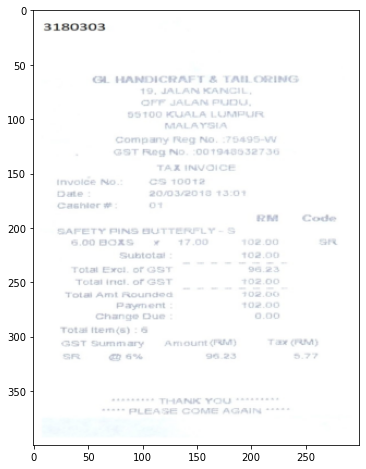

Labels: GL HANDICRAFT & TAIL ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Pred: GL HANDICRAFT & TAIL ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA



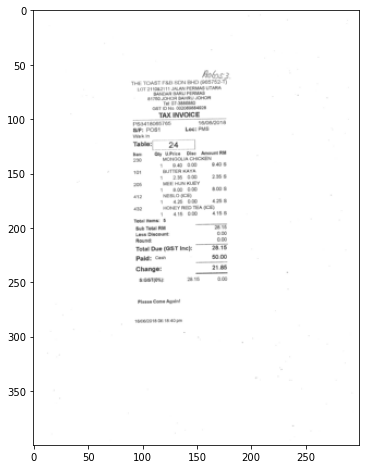

Labels: THE TOAST F&B SDN BHD [NL] LOT 2110&2111 JALAN PERMAS UTARA BANDAR BARU PERMAS 81750 JOHOR BAHRU JOHOR
Pred: THE TOAST F&B SDN BHD [NL] LOT 2110&2111 JALAN PERMAS UTARA BANDAR BARU PERMAS 81750 JOHOR BAHRU JOHOR



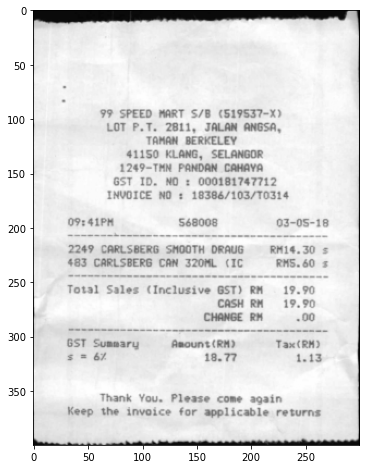

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1249-TMN PANDAN CAHAYA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA



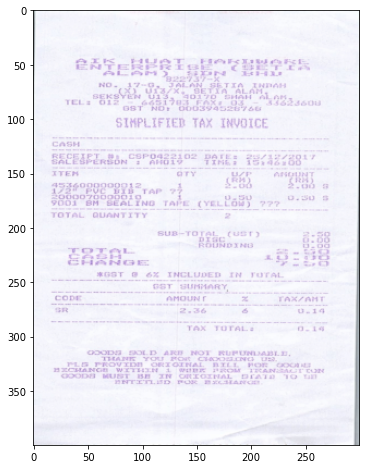

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13,



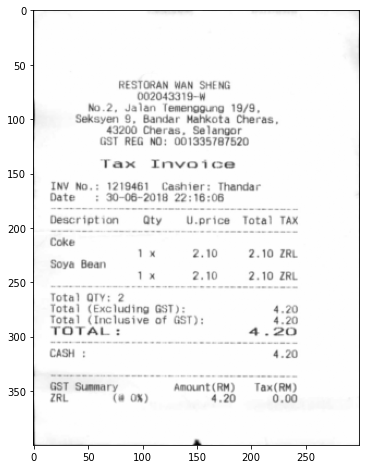

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR



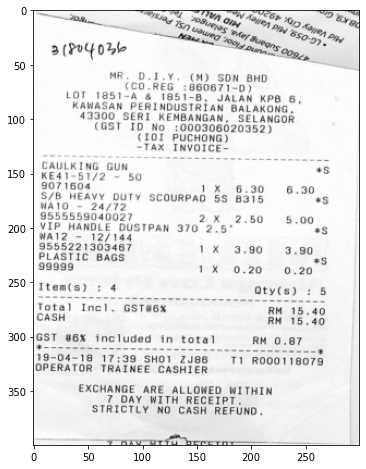

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



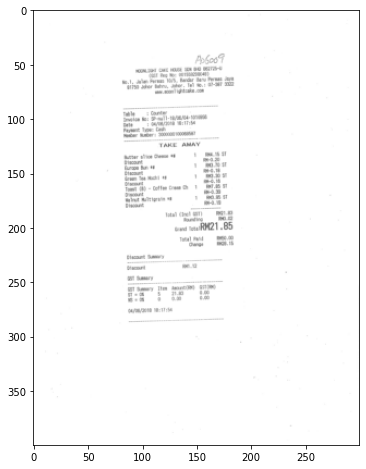

Labels: MOONLIGHT CAKE HOUSE SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR.
Pred: THE TOAST F&B SDN BHD [NL] LOT 2110&2111 JALAN PERMAS UTARA BANDAR BARU PERMAS 81750 JOHOR BAHRU JOHOR



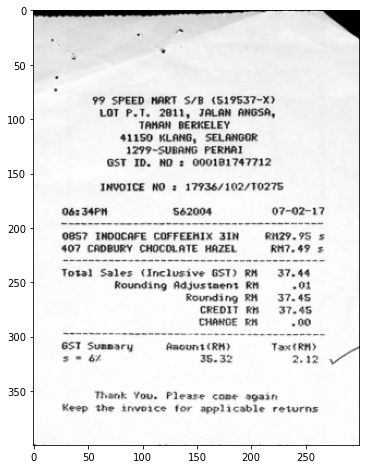

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-SUBANG PERDANA



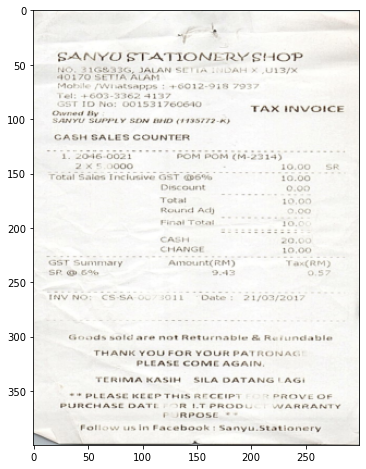

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR



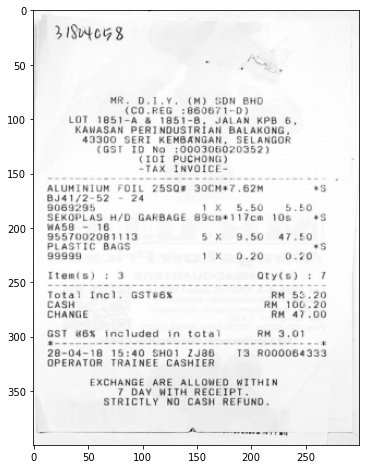

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



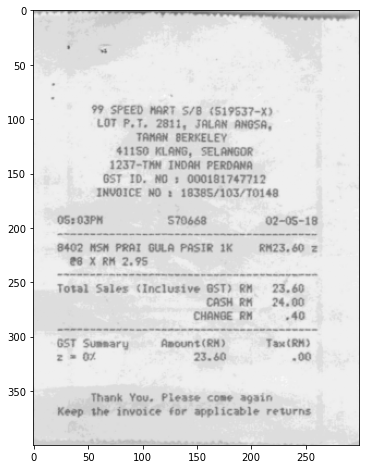

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA



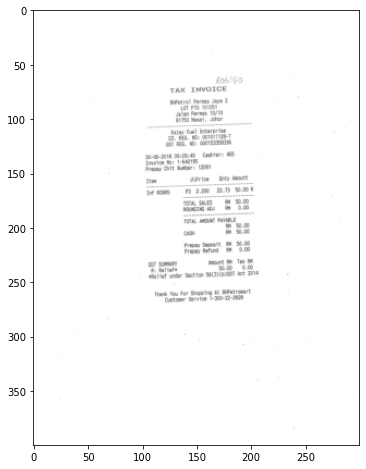

Labels: ESJAY FUEL ENTERPRISE [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Pred: TRIPLE SIX POINT ENTERPRISE 666 [NL] NO 14 & 16 JALAN PERMAS 4/3 BANDAR BARU PERMAS JAY



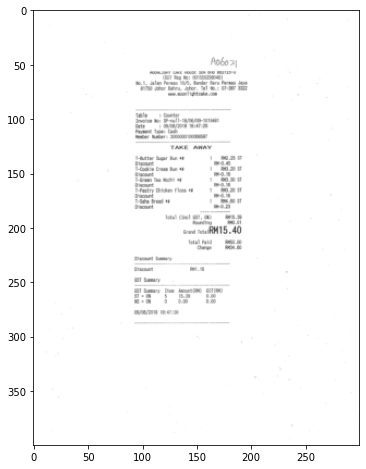

Labels: MOONLIGHT CAKE HOUSE SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR.
Pred: YONG CEN RESTAURANT [NL] NO.8,JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 MASAI JOHOR



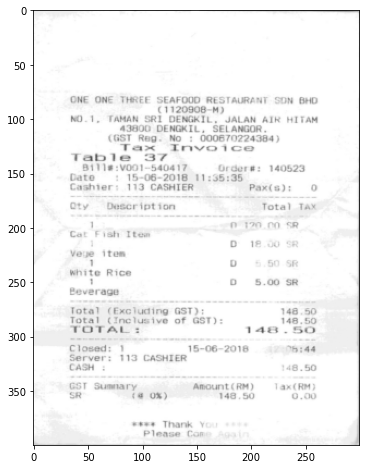

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: OWNER BY CASTLE BLUE S/B [NL] AVTIVO PLAZA,LOT B-F-11, BLOCK B NO.1, JALAN SS 6/5B, TAMAN SERDANG, KEPONG SELANGOR



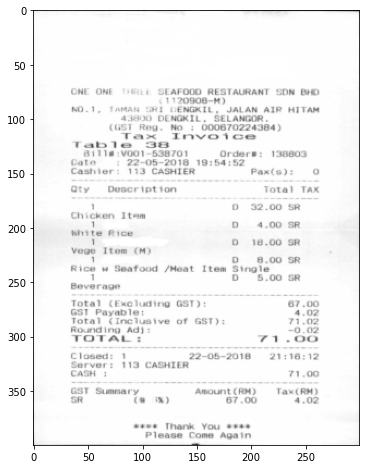

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: CHEF LEE SDN BHD [NL] NO.17, JALAN SS21/60, DAMANSARA UTAMA, 47400 PJ



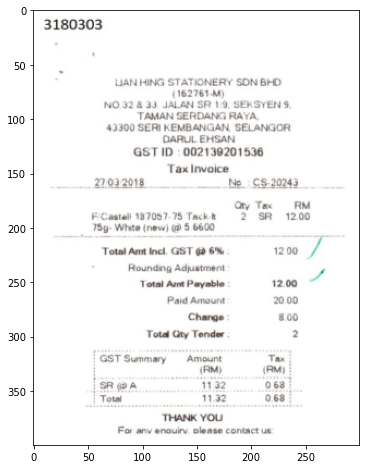

Labels: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN
Pred: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DAR



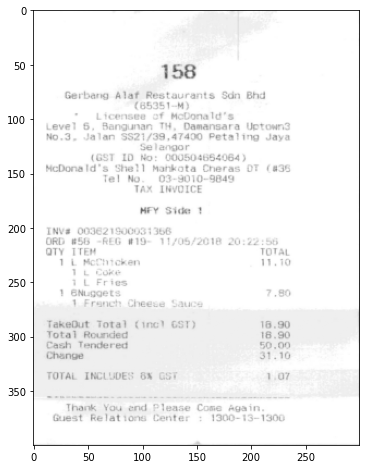

Labels: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Pred: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR



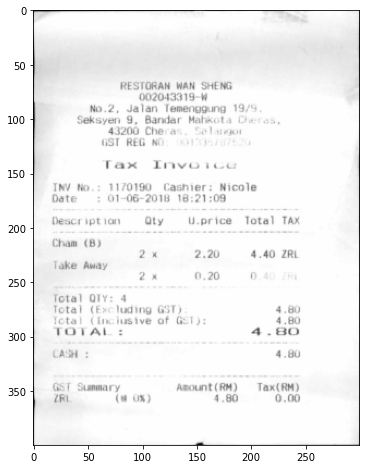

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR



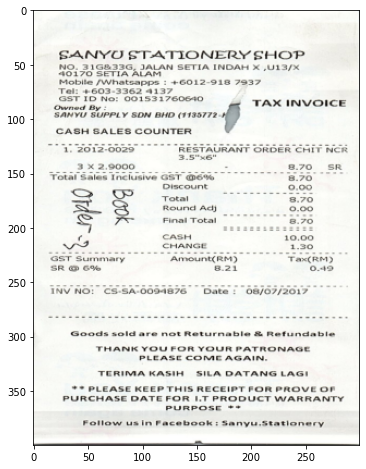

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: ADVANCO COMPANY [NL] NO.2-1-1&2 G JALAN SS6/3, DATARAN GLOMAC, SELANGOR DARUL EHSAN, MALAYSIA



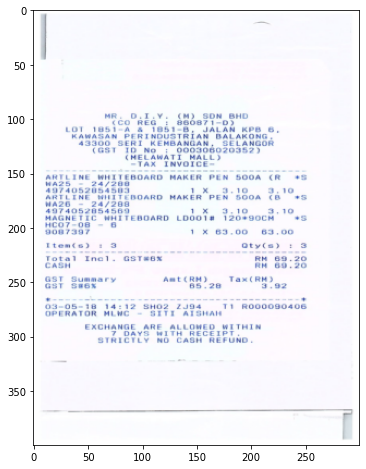

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



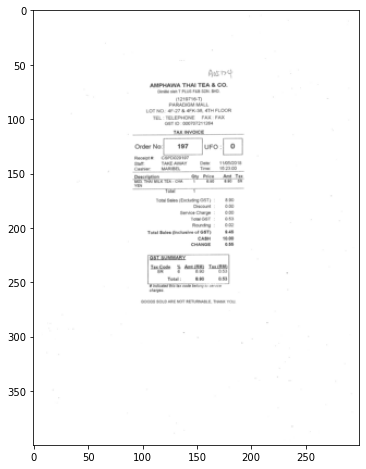

Labels: DIMILIKI OLEH T PLUS F&B SDN. BHD. [NL] PARADIGM MALL LOT NO.: 4F-27 & 4FK-38, 4TH FLOOR
Pred: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU



In [ ]:
batch = next(iter(test_dl))
batch[0] = batch[0].cuda()

test_model.eval()

with torch.no_grad():
    pred_tokens = test_model(batch)

decoded_preds = [test_model.tokenizer.decode(t) for t in pred_tokens]

images, labels, tokens = batch

for image, label, pred in zip(images, labels, decoded_preds):
    plt.figure(figsize=(6, 8))
    plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
    plt.show()
    print(f'Labels: {label}\nPred: {pred}\n')

## Observações

1. Abordagens usando pre-treino em OCR artificiais produzidos por texto (Como feito na Aula 7) foram avaliados, mas não demostraram grande vantagem para o problema.

2. Acredito que o uso de um pre-treino usando mais imagens  o dataset RVL-CDIP como feito no artigo da LayoutLM possa melhorar a performance uma vez que o data-set de usado aqui é muito pequeno.

3. O principal problema foi o tamanho do data-set que é pequeno fazendo que o modelo tenha overfitting muito facilmente.